In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
Path = "/content/gdrive/MyDrive/digipath/"

In [4]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [5]:
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

In [6]:
IMAGE_SIZE = 384

In [7]:
np.random.seed(32)
tf.random.set_seed(32)

Loading the Dataset

In [8]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "segmentations/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [9]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(Path)

print("Training data: ", len(train_x))
print("val data: ", len(valid_x))
print("Test data: ", len(test_x))

Training data:  96
val data:  12
Test data:  12


In [10]:
H = 384
W = 384
def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x[x==255]=1 # blue: class label: 1
    x[x==125]=2 # brown: class label: 2
    # x = x - 1
    # print(np.unique(x))
    x = x.astype(np.int32)
    return x

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset

def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        image = read_image(x)
        mask = read_mask(y)

        return image, mask

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.int32])
    mask = tf.one_hot(mask, 3, dtype=tf.int32)
    image.set_shape([H, W, 3])
    mask.set_shape([H, W, 3])

    return image, mask

In [12]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(Path)
print(f"Dataset: Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

Dataset: Train: 96 - Valid: 12 - Test: 12


In [13]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if pool == True:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x

def build_unet(shape, num_classes):
    inputs = Input(shape)

    """ Encoder """
    x1, p1 = conv_block(inputs, 16, pool=True)
    x2, p2 = conv_block(p1, 32, pool=True)
    x3, p3 = conv_block(p2, 48, pool=True)
    x4, p4 = conv_block(p3, 64, pool=True)

    """ Bridge """
    b1 = conv_block(p4, 128, pool=False)

    """ Decoder """
    u1 = UpSampling2D((2, 2), interpolation="bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 64, pool=False)

    u2 = UpSampling2D((2, 2), interpolation="bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 48, pool=False)

    u3 = UpSampling2D((2, 2), interpolation="bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool=False)

    u4 = UpSampling2D((2, 2), interpolation="bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool=False)

    """ Output layer """
    output = Conv2D(num_classes, 1, padding="same", activation="softmax")(x8)

    return Model(inputs, output)

model = build_unet((IMAGE_SIZE, IMAGE_SIZE, 3), 3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 384, 384, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 384, 384, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [16]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


shape = (384, 384, 3)
num_classes = 3
lr = 1e-5
batch_size = 8
epochs = 50


model = build_unet(shape, num_classes)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr))

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

train_steps = len(train_x)//batch_size
valid_steps = len(valid_x)//batch_size

callbacks = [
    ModelCheckpoint("model3.h5", verbose=1, save_best_model=True),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=5, verbose=1)
]

model.fit(train_dataset,
    steps_per_epoch=train_steps,
    validation_data=valid_dataset,
    validation_steps=valid_steps,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 1.2408
Epoch 1: saving model to model3.h5
12/12 [==============================] - 16s 271ms/step - loss: 1.2408 - val_loss: 1.1038 - lr: 1.0000e-05
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 1.1553
Epoch 2: saving model to model3.h5
12/12 [==============================] - 3s 239ms/step - loss: 1.1553 - val_loss: 1.1032 - lr: 1.0000e-05
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 1.0878
Epoch 3: saving model to model3.h5
12/12 [==============================] - 2s 205ms/step - loss: 1.0878 - val_loss: 1.0981 - lr: 1.0000e-05
Epoch 4/50
12/12 [==============================] - ETA: 0s - loss: 1.0315
Epoch 4: saving model to model3.h5
12/12 [==============================] - 2s 204ms/step - loss: 1.0315 - val_loss: 1.0853 - lr: 1.0000e-05
Epoch 5/50
12/12 [==============================] - ETA: 0s - loss: 0.9891
Epoch 5: saving model to model3.h5
12/12 [==================

In [17]:
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import cv2


H = 384
W = 384
num_classes = 3

In [18]:
model = tf.keras.models.load_model("/content/model3.h5")

  0%|          | 0/12 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  8%|▊         | 1/12 [00:02<00:26,  2.42s/it]

(384, 384, 3) (384, 10, 3) (384, 384, 3) (384, 10, 3) (384, 384, 3)
[6.6048108e-07 7.3168832e-07 7.6890484e-07 ... 9.6629322e-01 9.6905142e-01
 9.7357064e-01]
1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 2/12 [00:02<00:13,  1.32s/it]

(384, 384, 3) (384, 10, 3) (384, 384, 3) (384, 10, 3) (384, 384, 3)
[1.2708755e-06 1.4902884e-06 1.4938847e-06 ... 9.7522062e-01 9.7812563e-01
 9.7824281e-01]
1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 3/12 [00:03<00:08,  1.06it/s]

(384, 384, 3) (384, 10, 3) (384, 384, 3) (384, 10, 3) (384, 384, 3)
[2.8550444e-09 3.5114089e-09 3.7575552e-09 ... 9.8597091e-01 9.8597997e-01
 9.8658192e-01]
1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 4/12 [00:04<00:06,  1.27it/s]

(384, 384, 3) (384, 10, 3) (384, 384, 3) (384, 10, 3) (384, 384, 3)
[2.2048634e-07 2.2476509e-07 2.3307503e-07 ... 9.7629625e-01 9.7853357e-01
 9.7957373e-01]
1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 5/12 [00:04<00:04,  1.44it/s]

(384, 384, 3) (384, 10, 3) (384, 384, 3) (384, 10, 3) (384, 384, 3)
[1.0412173e-06 1.2667213e-06 1.5316127e-06 ... 9.9243814e-01 9.9254239e-01
 9.9338347e-01]
1/1 [==============================] - 0s 23ms/step


 50%|█████     | 6/12 [00:05<00:03,  1.56it/s]

(384, 384, 3) (384, 10, 3) (384, 384, 3) (384, 10, 3) (384, 384, 3)
[8.4197927e-07 8.7077689e-07 8.7282490e-07 ... 9.8877829e-01 9.8950642e-01
 9.9073035e-01]
1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 7/12 [00:05<00:03,  1.64it/s]

(384, 384, 3) (384, 10, 3) (384, 384, 3) (384, 10, 3) (384, 384, 3)
[4.1735635e-08 6.0063037e-08 6.1441170e-08 ... 9.9559790e-01 9.9563867e-01
 9.9611014e-01]
1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 8/12 [00:06<00:02,  1.73it/s]

(384, 384, 3) (384, 10, 3) (384, 384, 3) (384, 10, 3) (384, 384, 3)
[4.7964772e-06 5.5961973e-06 8.7934040e-06 ... 9.8540628e-01 9.8554593e-01
 9.8712349e-01]
1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 9/12 [00:06<00:01,  1.74it/s]

(384, 384, 3) (384, 10, 3) (384, 384, 3) (384, 10, 3) (384, 384, 3)
[3.2959960e-07 3.4092005e-07 4.0202531e-07 ... 9.8628831e-01 9.8797184e-01
 9.8865032e-01]
1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 10/12 [00:07<00:01,  1.78it/s]

(384, 384, 3) (384, 10, 3) (384, 384, 3) (384, 10, 3) (384, 384, 3)
[6.3980215e-06 6.8460954e-06 6.8932040e-06 ... 9.8024791e-01 9.8034370e-01
 9.8363757e-01]
1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 11/12 [00:07<00:00,  1.83it/s]

(384, 384, 3) (384, 10, 3) (384, 384, 3) (384, 10, 3) (384, 384, 3)
[2.9982495e-08 3.0612924e-08 3.3262715e-08 ... 9.8907030e-01 9.8917425e-01
 9.8964256e-01]
1/1 [==============================] - 0s 20ms/step


100%|██████████| 12/12 [00:08<00:00,  1.46it/s]

(384, 384, 3) (384, 10, 3) (384, 384, 3) (384, 10, 3) (384, 384, 3)
[3.0165873e-05 3.1278403e-05 3.5042391e-05 ... 9.7420925e-01 9.7503328e-01
 9.7542477e-01]


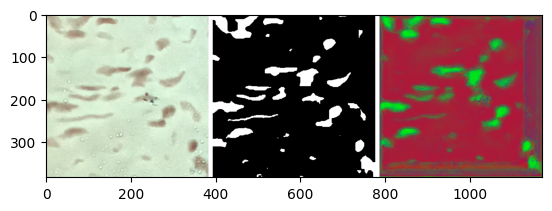

In [19]:
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
  name = x.split("/")[-1]
  x = cv2.imread(x, cv2.IMREAD_COLOR)
  x = cv2.resize(x, (W, H))
  x = x / 255.0
  x = x.astype(np.float32)

  y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
  y = cv2.resize(y, (W, H))   ## (384, 384)
  y[y==255]=1 # blue: class label: 1
  y[y==125]=2 # brown: class label: 2
  y = np.expand_dims(y, axis=-1) ## (384, 384, 1)
  y = y * (255/num_classes)
  y = y.astype(np.int32)
  y = np.concatenate([y, y, y], axis=2)

  p = model.predict(np.expand_dims(x, axis=0))[0]

  h, w, _ = x.shape
  line = np.ones((h, 10, 3)) * 255

  print(x.shape, line.shape, y.shape, line.shape, p.shape)
  print(np.unique(p))




  final_image = np.concatenate([x, line, y, line, p], axis=1)
  plt.imshow(final_image)